In [54]:
# Import necessary packages
import pandas as pd
import re
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from os import getcwd, path

In [2]:
# Read the datafile and display its contents
data = pd.read_csv("rt_reviews.csv", encoding = 'iso-8859-1')
data

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...
...,...,...
479995,rotten,Zemeckis seems unable to admit that the motio...
479996,fresh,Movies like The Kids Are All Right -- beautif...
479997,rotten,Film-savvy audiences soon will catch onto Win...
479998,fresh,An odd yet enjoyable film.


In [3]:
# Display the counts of each freshness
data.groupby(["Freshness"]).count()

,Review
Freshness,
fresh,240000
rotten,240000


<h3>Each freshness has at 240000 records, meaning the dataset is perfectly balanced.</h3>

In [4]:
# Data preprocessing
# Rename the column freshness to label
data.columns = ["Label", "Review"]
# Reorder the columns review first and label second
data = data[["Review", "Label"]]
# Replace the fresh and rotten label with 1 and 0 respectively for binary
# classification
data["Label"] = data["Label"].replace("fresh", 1).replace("rotten", 0)
data

,Review,Label
0,"Manakamana doesn't answer any questions, yet ...",1
1,Wilfully offensive and powered by a chest-thu...,1
2,It would be difficult to imagine material mor...,0
3,Despite the gusto its star brings to the role...,0
4,If there was a good idea at the core of this ...,0
...,...,...
479995,Zemeckis seems unable to admit that the motio...,0
479996,Movies like The Kids Are All Right -- beautif...,1
479997,Film-savvy audiences soon will catch onto Win...,0
479998,An odd yet enjoyable film.,1


In [5]:
# Split data into input and output lists
X = data.iloc[:, 0]
y = data.iloc[:, 1]

In [6]:
# Make the data lowercase
X = X.str.lower()

<h3>There is no need to remove non-alphanumeric characters when using tensorflow tokenizer, because it filters those characters automatically</h3>

In [7]:
# Display the adjusted data
X

0          manakamana doesn't answer any questions, yet ...
1          wilfully offensive and powered by a chest-thu...
2          it would be difficult to imagine material mor...
3          despite the gusto its star brings to the role...
4          if there was a good idea at the core of this ...
                                ...                        
479995     zemeckis seems unable to admit that the motio...
479996     movies like the kids are all right -- beautif...
479997     film-savvy audiences soon will catch onto win...
479998                          an odd yet enjoyable film. 
479999     no other animation studio, even our beloved p...
Name: Review, Length: 480000, dtype: object

In [ ]:
# Create a tokenizer object and fit it on the data
token_obj = Tokenizer()
token_obj.fit_on_texts(X)

In [ ]:
# Save the tokenizer for use with prediction later
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(token_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Load the tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    token_obj = pickle.load(handle)

In [9]:
# Split the data into 75% training and 25% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                    random_state = 23)

In [10]:
# Tokenize the training and test inputs
X_train_tokens = token_obj.texts_to_sequences(X_train)
X_test_tokens = token_obj.texts_to_sequences(X_test)

In [11]:
# Define the maximum length of a review for padding, and find the vocabulary
# size
MAX_LENGTH = 50
vocab_size = len(token_obj.word_index) + 1

In [12]:
# Display the size of the vocabulary, there are 102046 unique words
vocab_size

102046

In [13]:
# Pad the training and test input sets
X_train_pad = pad_sequences(X_train_tokens, maxlen = MAX_LENGTH,
                            padding = "post")
X_test_pad = pad_sequences(X_test_tokens, maxlen = MAX_LENGTH,
                            padding = "post")

In [14]:
# Set the embedding dimension, this is how many features will be learned for
# each word
EMBEDDING_DIM = 50

In [81]:
# Build our sentiment analysis model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = MAX_LENGTH))
model.add(LSTM(16, return_sequences = True))
model.add(LSTM(16, return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1, activation = 'sigmoid'))

In [82]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 50)            5102300   
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 16)            4288      
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 16)            2112      
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 5,110,829
Trainable params: 5,110,829
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Set the Adam optimizer and compile the model
opt = Adam(learning_rate = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt,
                metrics = ['accuracy'])

In [84]:
# Fit the model on the training data
hist = model.fit(X_train_pad, y_train, batch_size = 1000, epochs = 10,
                validation_data = (X_test_pad, y_test), verbose = 1).history

Epoch 1/10
360/360 [==============================] - 159s 442ms/step - loss: 0.4813 - accuracy: 0.7532 - val_loss: 0.3996 - val_accuracy: 0.8182
Epoch 2/10
360/360 [==============================] - 155s 431ms/step - loss: 0.3484 - accuracy: 0.8480 - val_loss: 0.3695 - val_accuracy: 0.8363
Epoch 3/10
360/360 [==============================] - 155s 431ms/step - loss: 0.2907 - accuracy: 0.8755 - val_loss: 0.3650 - val_accuracy: 0.8491
Epoch 4/10
360/360 [==============================] - 155s 431ms/step - loss: 0.2436 - accuracy: 0.8990 - val_loss: 0.3589 - val_accuracy: 0.8584
Epoch 5/10
360/360 [==============================] - 156s 433ms/step - loss: 0.2042 - accuracy: 0.9186 - val_loss: 0.3675 - val_accuracy: 0.8630
Epoch 6/10
360/360 [==============================] - 155s 431ms/step - loss: 0.1717 - accuracy: 0.9337 - val_loss: 0.3839 - val_accuracy: 0.8667
Epoch 7/10
360/360 [==============================] - 155s 429ms/step - loss: 0.1452 - accuracy: 0.9456 - val_loss: 0.4154 -

In [77]:
# Get current working directory
cwd = getcwd()

In [85]:
# Save model in an h5 file
model_path = path.join(cwd,'models', 'model-3_layer_16-lr_001.h5')
model.save(model_path)

In [86]:
# Save history in a pickle file
hist_path = path.join(cwd, 'histories', 'hist-3_layer_16-lr_001.pkl')
pickle.dump(hist, open(hist_path, 'wb'))

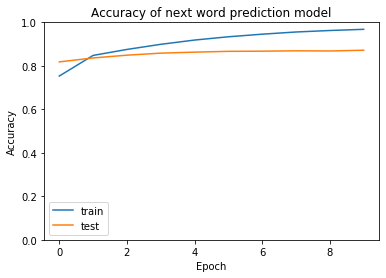

In [87]:
# Save graph in a jpg file
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Accuracy of next word prediction model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['train', 'test'])
plt.savefig('graphs/graph-3_layer_16-lr_001.jpg')

In [52]:
# Function for getting the sentiment scores of tweets
def predict_sentiment(data):
    results = []
    # Make all data lowercase
    data_lower = [i.lower() for i in data]
    # Tokenize the data
    data_tokens = token_obj.texts_to_sequences(data_lower)
    # Pad the data to make it the correct length
    data_pad = pad_sequences(data_tokens, maxlen = MAX_LENGTH,
                                padding = 'post')
    # Get the sentiment score
    scores = model.predict(data_pad)
    # For each sentence
    for i in range(len(data)):
        # If the score is above 0.5
        if scores[i][0] >= 0.5:
            # The sentiment is positive
            result = 'FRESH'
        # Otherwise, meaning it is below 0.5
        else:
            # The sentiment is negative
            result = 'ROTTEN'
        # Print the sentence, its sentiment, and the sentiment score
        print("The sentiment of the sentence \"" + data[i] + "\" is",
                result, "with a score of", scores[i][0])

In [90]:
# Make predictions on the 2 given data points
test = ["This movie was very boring",
        "I enjoyed this movie a lot",
        "The movie was okay, but not amazing",
        "The pacing was fairly slow, but the movie was enjoyable overall"]
predict_sentiment(test)

The sentiment of the sentence "This movie was very boring" is ROTTEN with a score of 0.011035442
The sentiment of the sentence "I enjoyed this movie a lot" is FRESH with a score of 0.9808721
The sentiment of the sentence "The movie was okay, but not amazing" is ROTTEN with a score of 0.23405984
The sentiment of the sentence "The pacing was fairly slow, but the movie was enjoyable overall" is FRESH with a score of 0.9388678
